<a href="https://colab.research.google.com/github/omarespejel/Hugging-Face-101-ES/blob/main/2_NLP_en_espa%C3%B1ol%3A_Fine-tuning_para_clasificar_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. NLP en español: Fine-tuning para clasificar tweets
por Omar U. Espejel (Twitter: [@espejelomar](https://twitter.com/espejelomar))


- Puedes escribirme vía Twitter en [@espejelomar](https://twitter.com/espejelomar?lang=en) 🐣. 

- Únete al [Discord de Hugging Face](https://t.co/1n75wi976V?amp=1).
  
- Checa el [diccionario inglés-español](https://www.notion.so/Ingl-s-para-la-programaci-n-bab11d9db5014f16b840bf8d22c23ac2) para programación.

## Instalación del modelo en español

Instalamos y descargamos BETO.

In [1]:
%%capture
!pip install transformers

Importamos lo necesario.

In [2]:
import torch
from transformers import BertForMaskedLM, BertTokenizer

Descargamos [`BETO` desde el Hub de Hugging Face](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased). El tokenizador lo dejamos con `do_lower_case` para que sí podamos aceptar palabras con mayúsculas. 

Descargamos [BETO desde el Hub de Hugging Face](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased). El tokenizador lo dejamos con `do_lower_case` para que sí podamos aceptar palabras con mayúsculas.

Hay dos modelos `BETO`, el [cased](dccuchile/bert-base-spanish-wwm-cased) y el [uncased](dccuchile/bert-base-spanish-wwm-uncased). 
- `Uncased`: todo el texto del diccionario está en minúsculas. Así fue entrenado. Por ejemplo, la palabra `Revolución` la convervierte en `revolución`.
- `Cased`: las palabras se mantienen. `Revolución` sigue siendo `Revolución`.

La versión `uncased` suele dar mejores resultados para la versión en inglés. Pero en aplicaciones donde las mayúsculas sean muy relevantes (ej. Name Entity Recognition(NER) o Part of Speech (POS)) servirá mejor la versión `cased`.

Para nuestro modelo que clasificará tweets pienso que los acentos y las mayúsculas no serán tan necesarias por lo que usaremos la versión `uncased`. Pero prueba ambos modelos!

In [3]:
tokenizer_español = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = BertForMaskedLM.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model.eval();

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

## Preparandonos

Si tenemos un GPU entonces, lo usamos.

In [4]:
if torch.cuda.is_available():    
    device = torch.device("cuda:0")
    print('GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

GPU: Tesla T4


### Obteniendo los datos

Notar que aún nuestros ids no son tensores, estos los podemos convertir facilmente ya sea a Pytorch o a Tensorflow.

In [5]:
import pandas as pd
import requests
import os

Usamos el módulo `os` para crear una nueva carpeta `dataset` donde guardaremos nuestra base de datos en formato xml que descargamos usando `requests`.

 

In [6]:
home = os.getcwd()

if not os.path.exists(home + '/dataset'):
    os.mkdir(home + '/dataset')

Vemos que se creo la carpeta `dataset`.

In [7]:
os.listdir()

['.config', 'dataset', 'sample_data']

Usamos el módulo `request` para descar la base de datos TASS 2019 para México.

In [8]:
URL = "http://tass.sepln.org/tass_data/dataset/TASS2019_country_MX_train.xml"

response = requests.get(URL)
with open('dataset/base_datos.xml', 'wb') as file:
    file.write(response.content)

In [9]:
import xml.etree.ElementTree as et 

xtree = et.parse("dataset/base_datos.xml")
xroot = xtree.getroot()

In [10]:
filas = []

for node in xroot: 
    tweet = node[2].text
    sentimiento = node[5][0][0].text

    filas.append({"contenido": tweet, "sentimiento": sentimiento})

In [11]:
df = pd.DataFrame(filas, columns = ["contenido", "sentimiento"])

Haremos nuestra base de datos más grande al importar también los datos de TASS nombrados como "dev".

In [12]:
URL = "http://tass.sepln.org/tass_data/dataset/TASS2019_country_MX_dev.xml"

response = requests.get(URL)
with open('dataset/base_datos_2.xml', 'wb') as file:
    file.write(response.content)

xtree = et.parse("dataset/base_datos_2.xml")
xroot = xtree.getroot()

filas = []

for node in xroot: 
    tweet = node[2].text
    sentimiento = node[5][0][0].text

    filas.append({"contenido": tweet, "sentimiento": sentimiento})

df_2 = pd.DataFrame(filas, columns = ["contenido", "sentimiento"])

In [13]:
os.listdir("dataset")

['base_datos_2.xml', 'base_datos.xml']

Hacemos que nuestro columna de sentimiento se vuelva númerica y eliminamos los ejemplos donde tengamos NONE en sentimiento.

In [14]:
%%capture
df = df[df.sentimiento != "NONE"]
df.loc[(df.sentimiento == 'N'),'sentimiento']=0
df.loc[(df.sentimiento == 'P'),'sentimiento']=1
df.loc[(df.sentimiento == 'NEU'),'sentimiento']=2

In [15]:
%%capture
df_2 = df_2[df_2.sentimiento != "NONE"]
df_2.loc[(df_2.sentimiento == 'N'),'sentimiento']=0
df_2.loc[(df_2.sentimiento == 'P'),'sentimiento']=1
df_2.loc[(df_2.sentimiento == 'NEU'),'sentimiento']=2

Unimos nuestros DataFrames...

In [16]:
df = df.append(df_2, ignore_index=True)

In [17]:
print('Número de ejemplos: {:,}\n'.format(df.shape[0]))

df.sample(10)

Número de ejemplos: 1,358



,contenido,sentimiento
696,Esperamos que disfrutes de este día con tus se...,1
332,@Tribuna_I Apenas inició el torneo y ya están ...,2
307,Siii te traje un tecuerdo @La_Joyita2 pero me ...,0
787,Como poder ser feliz con esa persona q amas,1
182,@LOMMX te amo porque te pones en su lugar a to...,1
60,"Hoy por fin no cene comida de la calle, hoy fu...",1
816,@shakira no te puedo llevar en mi bicicleta. M...,0
875,Esto de mudarme me agota y me da hueva recoger,0
704,Primer día de trabajo y estoy que me muero de ...,0
1232,@caelike #VerdadOretoCaeli Te reto a gritar te...,2


In [18]:
# df.loc[df.label == 0].sample(5)[['sentence', 'label']]

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

In [19]:
textos = df.contenido.to_list()
textos[:5]

["— ¿Nivel de inglés? — Alto. — Traduzca juguete. — Toy. — Úselo en una oración. — Toy triste. — Awww, vengache pa' acá. —",
 'Si soy de área 4 y con suerte pase mate IV y mate V ¿por que me ponen al profe qlero que es mega difícil pasar con el, en mi último año?',
 'Sabían que su after fav Teatro G. fue construido para mi y un día de estos (hoy) les voy a dar el placer de que me vean ahí metido !!',
 'Y hoy por primera vez me salí con el permiso de mi mujer pero no es eso el detalle, si no saber q estarán a mi lado y q llegaré a casa',
 '¿Para qué hacen coraje con Ambriz?, al final no lo van a correr y saldrá con su típica frase: "La culpa es mía, no de los jugadores"']

In [20]:
etiquetas = df.sentimiento.to_list()
etiquetas[:5]

[2, 0, 1, 1, 0]

### Tokenizando

¿Cuál es nuestro texto más largo?

In [21]:
max_len = 0

for text in textos:
  input_ids = tokenizer_español.encode(text, add_special_tokens=True)
  max_len = max(max_len, len(input_ids))

print('Máxima longitud: ', max_len)

Máxima longitud:  60


Es probable que vean en códigos y textos de hace unos meses el método `encode_plus()`, sin embargo actualmente se encuentra *deprecated* (obsoleto). Ahora la forma principal de *tokenize* es usando el metódo ya built-in en Python, `__call__()`:

> "El método `__call__` permite a los programadores de Python escribir clases donde las instancias se comportan como funciones y se pueden llamar como una función. Cuando se llama a la instancia como función; si este método está definido, `x(arg1, arg2, ...)` es una abreviatura de `x.__call__(arg1, arg2, ...)`." - Geeks for Geeks



In [22]:
encoded_texto_0 = tokenizer_español(
    textos[0],
    add_special_tokens = True,
    max_length = 60,
    truncation = True,
    padding = 'max_length',
    return_attention_mask = True,
    return_tensors = 'pt',
)

Arriba colocamos que queremos que el largo máximo de nuestros textos sea de 60. Esto significa que los textos de menos de 60 caracteres tendrán padding hasta completar los 60 valores.

Nos retorna una instancia de la clase BatchEncoding (link a documentación [link text](https://huggingface.co/transformers/_modules/transformers/tokenization_utils_base.html)). Esta clase se encuentra en la librería `transformers.tokenization_utils_base`.

In [23]:
type(encoded_texto_0)

transformers.tokenization_utils_base.BatchEncoding

Como colocamos `paddding = 'max_length'` que quiere decir que tendremos un tensor de tamaño 60. En este caso nuestro tensor no tiene esa dimension por lo que estamos forzando un padding que podemos notar con `attention_mask`: solamente tenemos 1s donde esta el texto y 0s donde hay padding.

In [24]:
encoded_texto_0['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [25]:
encoded_texto_0['input_ids'].shape

torch.Size([1, 60])

Actual,emte el vector de input_ids está en dos dimensiones. Idealmente lo queremos aplanado, es decir, en una sola dimensión.

Podemos aplanar el tensor así...

In [26]:
encoded_texto_0['input_ids'][-1].shape

torch.Size([60])

Así queda nuestro texto:

In [27]:
tokenizer_español.decode(encoded_texto_0['input_ids'][-1])

'[CLS] [UNK] ¿ nivel de inglés? [UNK] alto. [UNK] traduzca juguete. [UNK] toy. [UNK] úselo en una oración. [UNK] toy triste. [UNK] awww, vengache pa [UNK] acá. [UNK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

Así es originalmente:

In [28]:
textos[0]

"— ¿Nivel de inglés? — Alto. — Traduzca juguete. — Toy. — Úselo en una oración. — Toy triste. — Awww, vengache pa' acá. —"

Después de la prueba con un solo ejemplo, procedemos con todos nuestros textos. 

Creamos dos listas, una con los `input_ids` y otra con las `attention_masks`.

In [29]:
input_ids = []
attention_masks = []

for texto in textos:
  encoded_texto = tokenizer_español(
      texto,
      add_special_tokens = True,
      max_length = 60,
      truncation = True,
      padding = 'max_length',
      return_attention_mask = True,
      return_tensors = 'pt',
  )

  input_ids.append(encoded_texto['input_ids'])
  attention_masks.append(encoded_texto['attention_mask'])

Nos quedamos con dos listas de tensores, cada una con largo de nuestro set de datos.

In [30]:
len(input_ids), len(attention_masks)

(1358, 1358)

Concatenamos los tensores con `torch.cat()` que nos permite convertir en tensor una lista de tensores.

In [31]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [33]:
print(f' Nos quedamos ahora con dos tensores de la clase: {type(input_ids)}')

 Nos quedamos ahora con dos tensores de la clase: <class 'torch.Tensor'>


La forma de nuestros nuevos tensores tiene en la primera dimensión el número de ejemplos y en la segunda las palabras de cada enunciado. Podemos considerar que cada tweet de nuestro tensor de rango dos representa una oración pero ya tokenizada.

In [40]:
print(f'Esta es la forma de nuestro tensor rango dos con los input_ids de nuestros tweets: {input_ids.shape}\n')
print(f'Esta es la forma de nuestro tensor rango dos con los attention_masks de nuestros tweets: {attention_masks.shape}')  

Esta es la forma de nuestro tensor rango dos con los input_ids de nuestros tweets: torch.Size([1358, 60])

Esta es la forma de nuestro tensor rango dos con los attention_masks de nuestros tweets: torch.Size([1358, 60])


Creamos un tensor de rango uno con las etiquetas (el resultado correcto de la clasificación) de cada tweet.

In [37]:
etiquetas = torch.tensor(etiquetas)
print(f'Esta es la forma de nuestro tensor rango uno de etiquetas: {etiquetas.shape}')

La forma de nuestro tensor rango uno de etiquetas: torch.Size([1358])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


### Preparando el `TensorDataset`

Separamos en sets de entrenamiento y validación.

In [38]:
from torch.utils.data import TensorDataset, random_split

Usaremos `torch.utils.data.TensorDataset(*tensors)` que simplemente recibe tensores y los junta en un set de datos.

Estamos creando un set de datos con tres valores por observación:


1.   Los input_ids;
2.   Los attention_masks;
3.   Las etiquetas.




In [39]:
set_datos = TensorDataset(input_ids, attention_masks, etiquetas)

Creamos tamaños para nuestros sets: 80% serán para entrenamiento y 20% para validación.

In [ ]:
n = len(set_datos)

entrenamiento_tamaño = int(0.8 * n)
validación_tamaño = n - entrenamiento_tamaño

In [ ]:
print(f'El set de entrenamiento quedará con {entrenamiento_tamaño} obesrvaciones mientras que el de validación tendrá {validación_tamaño}.') 

El set de entrenamiento quedará con 1086 obesrvaciones mientras que el de validación tendrá 272.


In [ ]:
set_entrenamiento, set_validación = random_split(set_datos, [entrenamiento_tamaño, validación_tamaño])

Obtenemos un objeto de tipo Subset.

In [ ]:
type(set_entrenamiento)

torch.utils.data.dataset.Subset

Ahora convertimos en DataLoaders para que nuestros datos sean mezclados aleatoriamente y luego separados en batches.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler

Los autores recomiendan entrenar con batches de 16 o 32 ejemplos.

In [ ]:
batch_tamaño = 16

In [ ]:
dataloader_entrenamiento = DataLoader(
            set_entrenamiento,  
            sampler = RandomSampler(set_entrenamiento),
            batch_size = batch_tamaño
        )

dataloader_validacion = DataLoader(
            set_validación,
            sampler = RandomSampler(set_validación),
            batch_size = batch_tamaño 
        )

Los dataloaders son objetos iterables que podemos obtener usando `for`. Vemos que tenemos batches que contienen 16 elementos y el último los ejemplos que sobran.

In [ ]:
for batch in dataloader_entrenamiento:
  print(len(batch[0]))

## Entrenamiento

Se debe acomodar BERT para la tarea de clasificación. Para esto, HuggingFace nos da diferentes "interfaces" que acomodan las últimas capas de un BERT entrenado para aplicarse a diferentes tareas, como la clasificación.

En la [documentación](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html) de `transformers` se ven las interfaces para BERT.

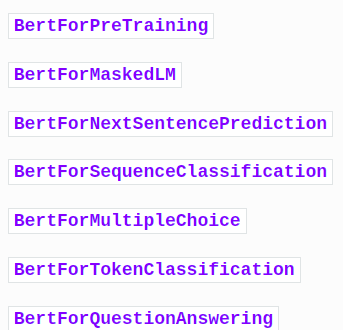



Usaremos BertForSequenceClassification. Esta interfaz toma los embeddigns entranados de nuestro BETO y agrega una capa linear al final que nos servirá para clasificar.

Obviamente esta última capa no esta entrenada. Lo que haremos con nuestro set de datos es fine-tuning. Es decir, entrenaremos la última capa (la de clasificación) desde cero mientras que las capas pre-entrenadas (BETO) las volveremos a entrenar con nuestro set de datos. Así, nuestro modelo estará más adecuado a nuestro uso particular de clasificar tweets.


In [ ]:
  from transformers import BertForSequenceClassification, BertConfig
  import transformers

Se pone interesante esto. Nuestro modelo BERT en español, BETO, es un *checkpoint* de una arquitectura similar a `BertForPreTraining`. *Checkpoint*: un punto hasta donde tenemos un modelo entrenado. Es como cuando guardamos nuestra partida en un videojuego.

Esto quiere decir que si usaremos a BETO para clasificación entonces sucederan dos cosas: 

1.   Vamos a tener capas de nuestro checkpoint BETO que no son utilizadas por la arquitectura de clasificación. Estas serán eliminadas automáticamente.

2.   Vamos a tener capas de la arquitectura para clasificación que no estarán en nuestro checkpoint BETO. Estas serán inicializadas con pesos aleatorios.

Al mencionar pque usaremos una arquitectura BertForSequenceClassification nos dirá justamente esto en un *warning*.

Esto quiere decir que para tener un buen modelo para clasificar tenemos que hacer un *fine-tuning*.

Creemos nuestro modelo. Nota que uno de lso argumentos que usaremos es `num_labels = 3`. Esto quiere decir que en la última capa, la de clasificación, creará espacio para tres labels. En este caso una sera para Negativo, otra pra Positivo y otra para Neutral. Nuestras tres categorías de sentimientos de los tweets.




In [ ]:
modelo = BertForSequenceClassification.from_pretrained(
    "espejelomar/beto-base-cased", 
    num_labels = 3, 
    output_attentions = False,
    output_hidden_states = False)

Some weights of the model checkpoint at espejelomar/beto-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model che

In [ ]:
type(modelo)

transformers.models.bert.modeling_bert.BertForSequenceClassification

Para utilizar con GPU y observar la estructura de nuestro modelo BETO para clasificar oraciones:

In [ ]:
modelo.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Optimizer & Learning Rate Scheduler

Seleccionamos: Batch size = 16; learning rate (Adam) = 2e-5; número de épocas = 3. Son valores recomendados por los autores del [paper de BERT](https://arxiv.org/pdf/1810.04805.pdf).

In [ ]:
optimizer = transformers.AdamW(modelo.parameters(), 
                               lr = 2e-5)

Definimos `total_steps` como las veces que optimizamos nuestros parámetros. En este caso vamos a optimizar con cada ejemplo de nuestro set de datos. Este valor lo multiplicamos por el número de épocas y tenemos el total de "steps".

In [ ]:
epocas = 3
total_steps = len(dataloader_entrenamiento) * epocas

scheduler = transformers.get_linear_schedule_with_warmup(optimizer, 
                                                         num_warmup_steps = 0,
                                                         num_training_steps = total_steps)

Con un el error de validación podemos identificar el overfitting.

**Entrenamiento:**
- Desembale nuestras entradas de datos y etiquetas
- Cargue datos en la GPU para acelerar
- Limpiar las pendientes calculadas en la pasada anterior.
    - En pytorch, los gradientes se acumulan de forma predeterminada (útil para cosas como RNN) a menos que los elimine explícitamente.
- Pase hacia adelante (alimentar datos de entrada a través de la red)
- Pase hacia atrás (propagación hacia atrás)
- Dile a la red que actualice los parámetros con optimizer.step ()
- Seguimiento de variables para monitorear el progreso

**Evaluación:**
- Desembale nuestras entradas de datos y etiquetas
- Cargue datos en la GPU para acelerar
- Pase hacia adelante (alimenta los datos de entrada a través de la red)
- Calcule la pérdida en nuestros datos de validación y realice un seguimiento de las variables para monitorear el progreso' - Fuente: Youtube - Bert.

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
entrenamiento_stats = []

In [ ]:
perdida_entrenamiento_total = 0

modelo.train();

Primero entendamos lo que nos retorna nuestro `modelo` (ver [documentación](https://huggingface.co/transformers/model_doc/bert.html) para un `BertForSequenceClassification`). Probamos con el primer ejemplo de nuestro set de datos. Para esto tomamos el `set_entrenamiento` (objeto de tipo `Subset`) y:


1.   Retiramos el primero ejemplo con `set_entrenamiento[0]`;
2.   Los ejemplos tienen tres partes, nuestros `input_ids`, los `attention_mask` y las `etiquetas`. Nosotros insertaremos estas tres partes en nuestro `modelo` por lo que los obtenemos con `set_entrenamiento[0][2]`, por ejemplo, para la `attention_mask`, y así respectivamente.
3. En la documentación vemos que en `input_ids` y `attention_maks` necesitamos ingresar `torch.LongTensor` de forma (`batch_size`, `sequence_length`). Por lo que tenemos que agregar una dimensión adicional a nuestro tensor con `set_entrenamiento[0][0][None, :]` (ver [tutorial sobre manipulación de tensores](https://hackernoon.com/manipulacion-de-tensores-en-pytorch-hlp32ip)).
4. Finalmente, como determinamos que `modelo` corra en un GPU entonces tenemos que hacer que nuestros tensores corran también en GPU; usamos `to(device)` donde esta había sido definida antes como `device = torch.device("cuda")`.



Lo que obtenemos de `modelo` depende de del `BertConfig` y los argumentos que ingresemos. Por ahora, vemos que `modelo` nos regresa una tupla de dos valores.


1.   La pérdida de forma (1,).
2.   Los logits, los valores antes de la aplicación de una función de activación, de forma (batch_size, config.num_labels).

Con el metódo `item()` podemos obtener el valor particular de los tensores.



In [ ]:
outputs = modelo(input_ids = set_entrenamiento[0][0][None, :].to(device),
                         attention_mask = set_entrenamiento[0][1][None, :].to(device),
                         labels = set_entrenamiento[0][2][None,].to(device)
                         )

In [ ]:
perdida = outputs.loss
logits = outputs.logits

In [ ]:
perdida.item()

0.7286878228187561

In [ ]:
for batch in dataloader_entrenamiento:
  print(batch)

Ahora hacemos todo junto. Así queda nuestro proceso de entrenamiento...

In [ ]:
# Tomamos cada batch dentro de nuestro dataloader_entrenamiento
# y lo partimos entre ids, maks y etiquetas.
for batch in dataloader_entrenamiento:
  b_input_ids = batch[0].to(device)
  b_input_masks = batch[1].to(device)
  b_input_etiquetas = batch[2].to(device)

  # Limpiamos los gradientes del último step de optimización
  modelo.zero_grad()

  # Ingresmos ids, masks y etiquetas a nuestro modelo para obtener los
  # logits y las pérdidas de cada step de optimización (guardado en output)
  outputs = modelo(input_ids = b_input_ids,
                           attention_mask = b_input_masks,
                           labels = b_input_etiquetas)
  
  # Sumamos la última pérdida a las pasadas. Estamos haciendo una
  # sumatoria para obtener la suma total de las pérdidas.
  perdida_entrenamiento_total += outputs.loss.item()
  
  # Obtenemos el gradiente de nuestros weights con respecto a la 
  # pérdida obtenida.
  outputs.loss.backward()

  # Pedimos que la norma de los gradientes sea máximo 1. No te preocupes
  # por esto, es para hacer nuestro modelo más preciso
  torch.nn.utils.clip_grad_norm_(modelo.parameters(), 1.0)

  # Optimizamos utilizando los gradientes
  optimizer.step()
  scheduler.step()

La pérdida promedio la obtenemos dividiendo la sumatoria de las pérdidas individuales entre el total de nuestros ejemplos.

In [ ]:
perdida_entrenamiento_promedio = perdida_entrenamiento_total / len(dataloader_entrenamiento)

print("  Pérdida promedio en entrenamiento: {}".format(perdida_entrenamiento_promedio))


  Pérdida promedio en entrenamiento: 0.7819388802437222


Con lo obtenido evaluamos el perfomance de nuestro `modelo`; lo colocamos en modelo `eval` que hace que el dropout se comporte de una forma diferente a si estuvieramos entrenando.

In [ ]:
modelo.eval();

In [ ]:
accuracy_validacion_total = 0
perdida_validacion_total = 0

En evaluación no es necesario registrar el camino tomado durante el forward propagation para después obtener los gradientes; colocamos `torch.no_grad()`. No vamos a usar gradientes porque no vamos a optimizar.

También utilizamos `logits.detach()` para separar los `logits` de la operación en el grafo y quedarnos con sus valores netos: "`tensor.detach()` crea un tensor que comparte almacenamiento con un tensor que no requiere grad [...] Debe usar `detach()` cuando intente eliminar un tensor de un gráfico de cálculo, y `clone()` como una forma de copiar el tensor mientras mantiene la copia como parte del grafo de cálculo del que proviene." ([link a respuesta en foro](https://discuss.pytorch.org/t/clone-and-detach-in-v0-4-0/16861/2))

Los `logits`, ya sin encontrarse incorporados al grafo de la red neuronal, son pasados a cpu con el metódo `cpu()` y luego es convertido en un arreglo de `numpy()`.

Las predicciones (logits) vamos a compararlas con los labels. Ambas variables estarán en formato numpy por lo que generamos una función en numpy que nos ayuda a obtener nuestra métrica de accuracy: el porcentaje de predicciones que tenemos correctas.

In [ ]:
import numpy as np

def accuracy(preds, labels):
    predicciones = np.argmax(preds, axis=1).flatten()
    etiquetas = labels.flatten()
    return np.sum(predicciones == etiquetas) / len(etiquetas)

In [ ]:
# Igual que en el entrenamiento obtenemos para cada batch de nuestro
# set de validación los ids, las masks y las etiquetas.
for batch in dataloader_validacion:
  
  b_input_ids = batch[0].to(device)
  b_input_masks = batch[1].to(device)
  b_input_etiquetas = batch[2].to(device)

  # No requerimos los gradientes por lo que obtenemos los outputs
  # con torch.no_grad()
  with torch.no_grad():
    outputs = modelo(input_ids = b_input_ids,
                             attention_mask = b_input_masks,
                             labels = b_input_etiquetas)

  # Obtenemos la pérdida total  
  perdida_validacion_total += outputs.loss.item()

  # Sacamos los logits del grafo y los pasamos a cpu y a numpy
  logits = outputs.logits.detach().cpu().numpy()
  
  # Lo mismo con los labels
  label_ids = b_input_etiquetas.to('cpu').numpy()
  
  # Hacemos una sumatoria de la accuracy de cada batch
  accuracy_validacion_total += accuracy(logits, label_ids)

In [ ]:
accuracy_validacion_promedio = accuracy_validacion_total / len(dataloader_validacion)
print("  Accuracy: {}".format(accuracy_validacion_promedio))

perdida_validacion_promedio = perdida_validacion_total / len(dataloader_validacion)
print("  Pérdida de validación: {}".format(perdida_validacion_promedio))

  Accuracy: 0.7683823529411765
  Pérdida de validación: 0.621093313483631


Obtenemos las estadísticas del entrenamiento de esta epoch.

In [ ]:
entrenamiento_stats.append(
    {
        'epoch': 1,
        'Training Loss': perdida_entrenamiento_promedio,
        'Valid. Loss': perdida_validacion_promedio,
        'Valid. Accur.': accuracy_validacion_promedio,
     }
)

Ahora coloquemos todo nuestro entrenamiento dentro de un `for` en el que se definen las siguientes epochs. Originalmente así habríamos hecho el entrenamiento pero antes es bueno partirlo en sus componentes para entenderlo mejor.

Nota que cada época una vez entrenada la vamos a pasar por valdiación. Todo en el mismo loop.

In [ ]:
epochs = 2

for epoch in range(0, epochs):

  #######################################################
  #################### ENTRENAMIENTO ####################
  #######################################################

  # Colocamos algunos comentarios que nos sirven de guía
  print("")
  print("======= Época {:} / {:} ======".format(epoch + 1, epochs))
  print("Entrenando...")

  # Ponemos nuestro modelo en modo train
  modelo.train()

  # Repetimos el entrenamiento de arriba
  for step, batch in enumerate(dataloader_entrenamiento):

    # Cada optimización de cinco batches nos va a avisar
    if step % 5 == 0 and not step == 0:
      print('  Batch {:>5,}  de  {:>5,}.'.format(step, len(dataloader_entrenamiento)))

    
    b_input_ids = batch[0].to(device)
    b_input_masks = batch[1].to(device)
    b_input_etiquetas = batch[2].to(device)

    modelo.zero_grad()

    outputs = modelo(input_ids = b_input_ids,
                            attention_mask = b_input_masks,
                            labels = b_input_etiquetas)
    
    perdida_entrenamiento_total += outputs.loss.item()
    outputs.loss.backward()
    torch.nn.utils.clip_grad_norm_(modelo.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

  perdida_entrenamiento_promedio = perdida_entrenamiento_total / len(dataloader_entrenamiento)

  # Avisamos cual fue la pérdida promedio del entrenamiento
  print("  Pérdida promedio en entrenamiento: {}".format(perdida_entrenamiento_promedio))



  #######################################################
  #################### VALIDACIÓN #######################
  #######################################################
  print("")
  print("Validando...")

  # Seguimos los pasos de lo que ya hicimos arriba; nada nuevo
  accuracy_validacion_total = 0
  perdida_validacion_total = 0

  for batch in dataloader_validacion:
  
    b_input_ids = batch[0].to(device)
    b_input_masks = batch[1].to(device)
    b_input_etiquetas = batch[2].to(device)

    with torch.no_grad():
      outputs = modelo(input_ids = b_input_ids,
                              attention_mask = b_input_masks,
                              labels = b_input_etiquetas)
      
    perdida_validacion_total += outputs.loss.item()

    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_input_etiquetas.to('cpu').numpy()

    accuracy_validacion_total += accuracy(logits, label_ids)
  
  accuracy_validacion_promedio = accuracy_validacion_total / len(dataloader_validacion)
  print("  Accuracy: {0:.2f}".format(accuracy_validacion_promedio))

  perdida_validacion_promedio = perdida_validacion_total / len(dataloader_validacion)


  print("  Validation Loss: {0:.2f}".format(perdida_validacion_promedio))

  # Solo tenemos como nuevo que vamos a guardar nuestros resultados
  # de cada época dentre de nuestra lista entrenamiento_stats. Es bueno 
  # para referencia
  entrenamiento_stats.append(
      {
          # Normalmente sería epoch +1 pero arriba ya hicimos un loop de
          # entrenamiento
          'epoch': epoch + 2,
          'Training Loss': perdida_entrenamiento_promedio,
          'Valid. Loss': perdida_validacion_promedio,
          'Valid. Accur.': accuracy_validacion_promedio,
      }
  )



======= Época 1 / 2 ======
Entrenando...
  Batch     5  de     68.
  Batch    10  de     68.
  Batch    15  de     68.
  Batch    20  de     68.
  Batch    25  de     68.
  Batch    30  de     68.
  Batch    35  de     68.
  Batch    40  de     68.
  Batch    45  de     68.
  Batch    50  de     68.
  Batch    55  de     68.
  Batch    60  de     68.
  Batch    65  de     68.
  Pérdida promedio en entrenamiento: 1.309692367692204

Validando...
  Accuracy: 0.78
  Validation Loss: 0.64

======= Época 2 / 2 ======
Entrenando...
  Batch     5  de     68.
  Batch    10  de     68.
  Batch    15  de     68.
  Batch    20  de     68.
  Batch    25  de     68.
  Batch    30  de     68.
  Batch    35  de     68.
  Batch    40  de     68.
  Batch    45  de     68.
  Batch    50  de     68.
  Batch    55  de     68.
  Batch    60  de     68.
  Batch    65  de     68.
  Pérdida promedio en entrenamiento: 1.689870714703027

Validando...
  Accuracy: 0.76
  Validation Loss: 0.67


Usaremos nuestra lista entrenamiento_stats para crear un DataFrame de pandas. Así 1) veremos más claramente nuestros resultados y 2) podemos graficar.

In [ ]:
import pandas as pd

# Queremos que los DataFrames de pandas tengan solo dos décimales
pd.set_option('precision', 2)

# Creamos el DaraFrame
df_stats = pd.DataFrame(data=entrenamiento_stats)

# La época funcionará como nuestro índice
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,0.78,0.62,0.77
2,1.31,0.64,0.78
3,1.69,0.67,0.76


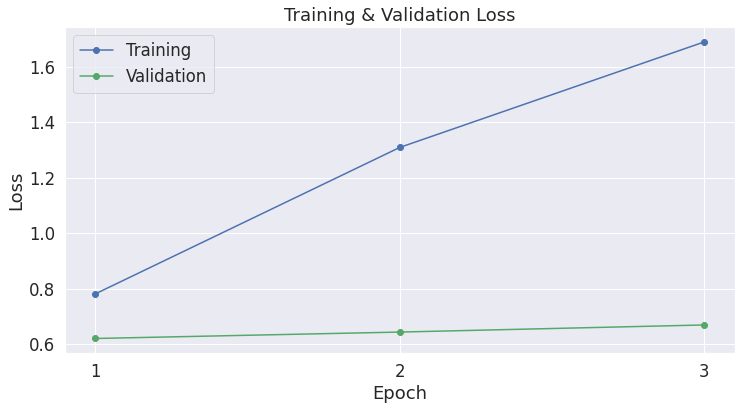

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

Guardamos con las mejores prácticas de HuggingFace.

In [ ]:
hasattr(model, 'module')

False

In [ ]:
if not os.path.exists(home + '/modelo_guardar/'):
    os.makedirs(home + '/modeo_guardar/')

print("Guardando modelo en {:}".format(home + '/modelo_guardar/'))

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
modelo_a_guardar = modelo.module if hasattr(modelo, 'module') else modelo  # Take care of distributed/parallel training
modelo_a_guardar.save_pretrained(home + '/modelo_guardar/')
tokenizer_español.save_pretrained(home + '/modelo_guardar/')


Guardando modelo en /content/modelo_guardar/


('/content/modelo_guardar/tokenizer_config.json',
 '/content/modelo_guardar/special_tokens_map.json',
 '/content/modelo_guardar/vocab.txt',
 '/content/modelo_guardar/added_tokens.json')